# Visualize Results for SciTech Paper 2022
For the SciTech Paper we plan to add an additional subsection to the results chapter in which we combine all three enhancements/improvements made in the UVLM on the Flex Op demonstrator model. Therefore, we will include the following parts:
- Comparison of lift distribution and deformation for 1g and 5g with Jurij's paper
- Lift response and wind bending moment caused by gust for different wake generation schemes
- Viscous drag corrections

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import h5py as h5

### Define some useful functions first

In [41]:
# plot function
def plot_data(x_data, y_data, list_legend_labels, xlabel, ylabel):
    for i in range(len(list_legend_labels)):
        plt.plot(x_data, y_data[i, :], label = list_legend_labels[i])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.show()

## 1) Verification of Lift Distribution and Deformation 
Compare resulting lift distribution and deformation of wings to data presented by TU Delft in https://arc.aiaa.org/doi/pdf/10.2514/6.2018-2153.

### Read Data

In [3]:
# Get Data from TU Delft (Extracted with webplotdigitzer)
file = '../01_case_files/flexOp_data/tudelft_results_reference_one_and_five_g.csv'
list_parameters = ['Lift Distribution', 'OOP Deformation', 'Torsional Deformation', 'Local AoA']
list_ylabels = ['dL/ds [N/m]', 'dz [m]', r'$\Theta$ [deg]', r'$\alpha$ [deg]']
list_load_cases = ['1g', '5g']
df_tud = pd.read_csv(file,skiprows = 2, header = None, sep = ";")

In [28]:
# Get Data from SHARPy
# index 0: 1g index 1: 5g
list_case_names = ['flex_op_lifting']
list_lift_distribution = []
num_cases = len(list_case_names)
list_hd_files_verification = []



for case in list_case_names:
    file = '../02_data_visualization/output/%s/savedata/%s.data.h5' % (case, case)
    list_hd_files_verification.append(h5.File(file, 'r'))
    df_lift_distribution = pd.read_csv('../02_data_visualization/output/%s/lift_distribution_0.csv'%(case))
    
    node_tip_left = np.argmax(np.array(list_hd_files_verification[0]['data']['structure']['timestep_info']['00000']['postproc_cell']['coords_a'])[:,1])
    list_lift_distribution.append(df_lift_distribution[['y', 'z' ,'fz', 'cl']].iloc[:node_tip_left,:])


# Get spanwise torsion and deformation
matrix_spanwise_loads = np.zeros((num_cases, node_tip_left, 6))
matrix_spanwise_oop_deformation = np.zeros((num_cases, node_tip_left))
for i_node in range(node_tip_left): 
    for icase in range(num_cases):
        matrix_spanwise_loads[icase, i_node,:] = np.array(list_hd_files_verification[icase]['data']['structure']['timestep_info']['00000']['postproc_cell']['loads'])[i_node,:]
        matrix_spanwise_oop_deformation[icase, i_node] = np.array(list_hd_files_verification[icase]['data']['structure']['timestep_info']['00000']['postproc_cell']['coords_a'])[i_node,2]

In [49]:
list_hd_files_verification[0]['data']['structure']['timestep_info']['00000'].keys()

<KeysViewHDF5 ['_read_as', 'dqddt', 'dqdt', 'for_acc', 'for_pos', 'for_vel', 'forces_constraints_FoR', 'forces_constraints_nodes', 'gravity_forces', 'in_global_AFoR', 'mb_FoR_acc', 'mb_FoR_pos', 'mb_FoR_vel', 'mb_dict', 'mb_dquatdt', 'mb_quat', 'num_elem', 'num_node', 'num_node_elem', 'pos', 'pos_ddot', 'pos_dot', 'postproc_cell', 'postproc_node', 'psi', 'psi_ddot', 'psi_dot', 'q', 'quat', 'runtime_generated_forces', 'steady_applied_forces', 'total_forces', 'total_gravity_forces', 'unsteady_applied_forces']>

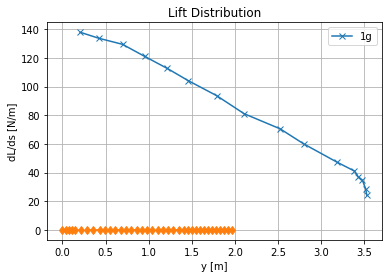

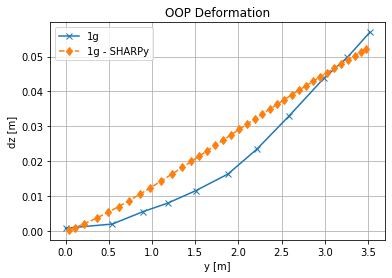

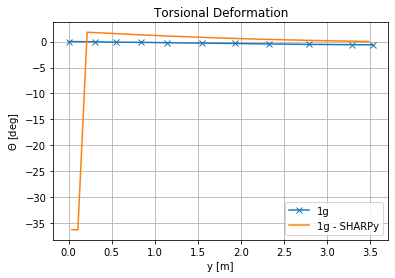

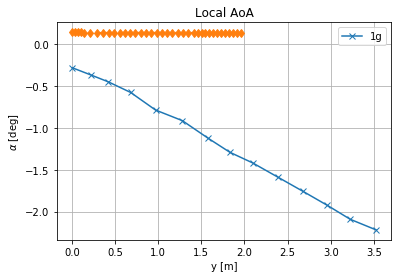

In [29]:
# Plot TU Delft Data
counter = 0
y_coordinates = np.array(list_hd_files_verification[0]['data']['structure']['timestep_info']['00000']['postproc_cell']['coords_a'])[:node_tip_left,1]
for para in list_parameters:
    for counter_case, load_case in enumerate(list_load_cases):
        if load_case == '1g':
            plt.plot(df_tud.iloc[:,counter], df_tud.iloc[:,counter + 1], '-x', label = load_case)
            if para == 'Lift Distribution':
                # TODO: convert data to dL/ds
                plt.plot(list_lift_distribution[counter_case].iloc[:,0],
                        list_lift_distribution[counter_case].iloc[:,1],
                        '--d')
            elif para == 'OOP Deformation':
                plt.plot(y_coordinates,
                         matrix_spanwise_oop_deformation[counter_case, :],
                        '--d',
                         label = load_case + " - SHARPy")  
                # #matrix_spanwise_loads[counter_case, :,4], 
            elif para == 'Torsional Deformation':
                plt.plot(y_coordinates,
                         matrix_spanwise_loads[counter_case, :,3],
                         label = load_case + " - SHARPy")   
            elif para == 'Local AoA':                
                node_tip_left = list_lift_distribution[counter_case].iloc[:,0].idxmax()
                plt.plot(list_lift_distribution[counter_case].iloc[:,0],
                        list_lift_distribution[counter_case].iloc[:,-1]/2*np.pi,
                        '--d')
                
        counter += 2
    if counter%4 == 0:
        
        plt.title(para)
        plt.xlabel('y [m]')
        plt.ylabel(list_ylabels[int(counter/4-1)])
        plt.legend()
        plt.grid()
        plt.show()

## 2) New Wake Discretisation Strategy
For the SciTech paper, we will compute the gust response of the Flex OP demonstrator model for SHARPy's normal wake and the new implemented discretized wake implemented by Arturo. Here, we will plot the lift and structural response to various 1-cos gust inputs. To point out the advantage of the new method, we will also compare the computation time of both approaches.

### Read Data

In [35]:
# index 0: normal wake, index 1: discretised wake
list_case_names = ['flex_op_wake', 'flex_op_wake_discretised']
num_cases = len(list_case_names)
list_hd_files = []
for case in list_case_names:
    file = '../02_data_visualization/output/%s/savedata/%s.data.h5' % (case, case)
    list_hd_files.append(h5.File(file, 'r'))

### Plot Data

#### To-Do:
- plot Function
- Compute lift coefficients
- Update root coordinate (junction at fuselage)
- Update structural properties for non aero_forces on wing beam
- Get time and normalize it (t[s] * U[m/s] / c[m])
- Table computational time 

In [36]:
# Setup Parameter
ts_max = 600
n_surfaces = 4 #include tail
list_time_steps_str = list(list_hd_files[1]['data']['aero']['timestep_info'].keys())[1:ts_max + 1]
list_time_steps_int = [int(ts) for ts in list_time_steps_str]


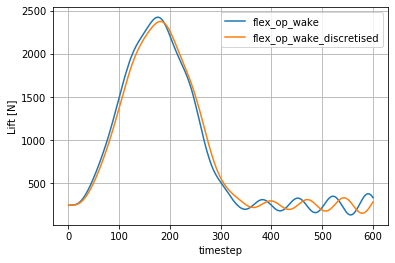

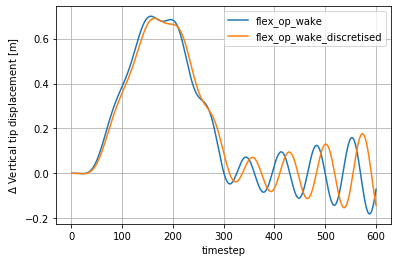

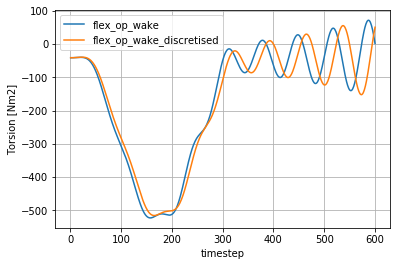

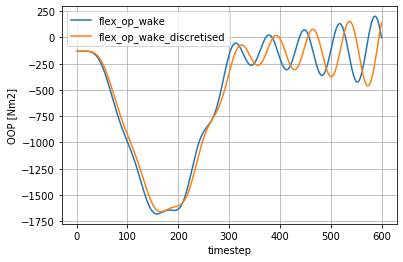

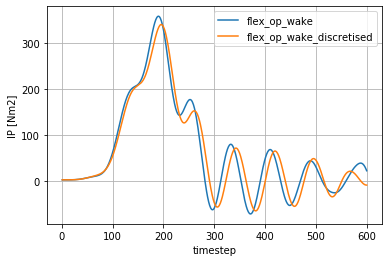

In [40]:
# Get Data
matrix_lift_steady = np.zeros((num_cases, ts_max))
matrix_tip_displacement = np.zeros((num_cases, ts_max))
matrix_root_loads = np.zeros((num_cases, ts_max, 6))
node_tip_left = np.argmax(np.array(list_hd_files[0]['data']['structure']['timestep_info']['00079']['pos'])[:,1])
node_root = 0
for counter, ts_str in enumerate(list_time_steps_str):
    for icase in range(num_cases):
        matrix_lift_steady[icase, counter] = np.array(list_hd_files[icase]['data']['structure']['timestep_info'][ts_str]['total_forces'])[2]
        matrix_tip_displacement[icase, counter] = np.array(list_hd_files[icase]['data']['structure']['timestep_info'][ts_str]['pos'])[node_tip_left, 2] # 1:= y_coordinate
        matrix_root_loads[icase, counter,:] = np.array(list_hd_files[icase]['data']['structure']['timestep_info'][ts_str]['postproc_cell']['loads'])[node_root,:]

matrix_tip_displacement[0, :] -= matrix_tip_displacement[0, 0]
matrix_tip_displacement[1, :] -= matrix_tip_displacement[1, 0]

# Generate Plots       
# C_L over time
plot_data(list_time_steps_int, matrix_lift_steady, list_case_names, "timestep", "Lift [N]")
# tip displacement over time
plot_data(list_time_steps_int, matrix_tip_displacement, list_case_names, "timestep", "$\Delta$ Vertical tip displacement [m]")
# Loads at Root
ylabels = ['Torsion [Nm2]', 'OOP [Nm2]', 'IP [Nm2]']
for i in range(3):    
    plot_data(list_time_steps_int, matrix_root_loads[:,:,3 + i], list_case_names, "timestep", ylabels[i])

## 3) Polar Correction
Compute the viscous drag for the case above (clamped aircraft + 1-cos gust?)
Note: From Jurij's paper we know that the airfoil thickness is between 10% and 8% (root to tip).